In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
# Load dataset
path = "/content/loangrant.csv"
df = pd.read_csv(path, low_memory=False)
print("Shape:", df.shape)
display(df.columns.tolist())


Shape: (111107, 19)


['Loan ID',
 'Customer ID',
 'Loan Status',
 'Current Loan Amount',
 'Term',
 'Credit Score',
 'Years in current job',
 'Home Ownership',
 'Annual Income',
 'Purpose',
 'Monthly Debt',
 'Years of Credit History',
 'Months since last delinquent',
 'Number of Open Accounts',
 'Number of Credit Problems',
 'Current Credit Balance',
 'Maximum Open Credit',
 'Bankruptcies',
 'Tax Liens']

In [ ]:
# Identify target column
possible_targets = ["Loan Status", "Loan_Status", "Outcome", "target", "approved", "loan_status"]
target_col = None
for name in possible_targets:
    if name in df.columns:
        target_col = name
        break
if target_col is None:
    target_col = df.columns[-1]
print("Using target column:", target_col)
display(df[target_col].value_counts().head())


Using target column: Loan Status


,count
Loan Status,
Fully Paid,85934
Charged Off,25173


In [ ]:
# Drop obvious identifier columns if present
drop_candidates = [c for c in ['Loan ID', 'Customer ID', 'Loan_ID', 'Customer_ID'] if c in df.columns]
print("Dropping identifiers (if any):", drop_candidates)
df = df.drop(columns=drop_candidates)

Dropping identifiers (if any): ['Loan ID', 'Customer ID']


In [ ]:
# Preprocess missing
threshold = int(0.5 * df.shape[1])
df = df[df.isna().sum(axis=1) <= threshold].reset_index(drop=True)
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64]:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode().iloc[0]).astype(str)

In [ ]:
# Split X, y
X = df.drop(columns=[target_col])
y = df[target_col].copy()

le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)
n_classes = len(le_target.classes_)
print("Target classes:", list(le_target.classes_), "n_classes =", n_classes)


Target classes: ['Charged Off', 'Fully Paid'] n_classes = 2


In [ ]:
# Identify categorical vs numeric, force object columns to string
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Num cols:", len(num_cols), "Cat cols:", len(cat_cols))


Num cols: 10 Cat cols: 6


In [ ]:
# For categorical columns with high cardinality, use label encoding; else one-hot
onehot_cols = []
label_encode_cols = []
for col in cat_cols:
    nunq = X[col].nunique()
    if nunq > 50:
        label_encode_cols.append(col)
    else:
        onehot_cols.append(col)
print("One-hot cols:", len(onehot_cols), "Label-encode cols:", len(label_encode_cols))


One-hot cols: 4 Label-encode cols: 2


In [ ]:
# Apply encodings
X_proc = X.copy()
# Label-encode high-cardinality categorical columns
for col in label_encode_cols:
    X_proc[col] = LabelEncoder().fit_transform(X_proc[col].astype(str))

In [ ]:
# One-hot encode the remaining categorical columns
if len(onehot_cols) > 0:
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe_arr = ohe.fit_transform(X_proc[onehot_cols].astype(str))
    ohe_names = ohe.get_feature_names_out(onehot_cols)
    # Concatenate numeric + label-encoded cols + ohe arr
    remaining_cols = [c for c in X_proc.columns if c not in onehot_cols]
    remaining_arr = X_proc[remaining_cols].to_numpy()
    if remaining_arr.ndim == 1:
        remaining_arr = remaining_arr.reshape(-1, 1)
    X_proc_arr = np.hstack([ohe_arr.toarray() if hasattr(ohe_arr, 'toarray') else ohe_arr, remaining_arr.astype(float)])
    feature_names = list(ohe_names) + remaining_cols
else:
    X_proc_arr = X_proc.to_numpy().astype(float)
    feature_names = X_proc.columns.tolist()

print("Processed shape:", X_proc_arr.shape)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_proc_arr)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.30, random_state=42, stratify=y_enc)
print("Train / Test shapes:", X_train.shape, X_test.shape)

Processed shape: (111107, 45)
Train / Test shapes: (77774, 45) (33333, 45)


In [ ]:
# Batch size rule
N = X_train.shape[0]
approx = int(math.sqrt(N))
pow2 = 1
while pow2 < approx:
    pow2 *= 2
prev_pow2 = pow2 // 2
batch_size = prev_pow2 if abs(prev_pow2-approx)<=abs(pow2-approx) else pow2
batch_size = max(8, batch_size)
print(f"Chosen batch_size = {batch_size} (sqrt heuristic nearest power of 2)")

Chosen batch_size = 256 (sqrt heuristic nearest power of 2)


In [ ]:
# Architectures
architectures = {
    "A_1hidden_16": (16,),
    "B_2hidden_32_16": (32,16),
    "C_3hidden_64_32_16": (64,32,16),
    "D_1hidden_8": (8,)
}
results = {}
for name, hidden in architectures.items():
    print("Training", name)
    clf = MLPClassifier(hidden_layer_sizes=hidden, activation='relu', solver='adam',
                        batch_size=batch_size, max_iter=300, random_state=42)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    results[name] = {"hidden": hidden, "train_acc": train_acc, "test_acc": test_acc,
                     "y_train_pred": y_train_pred, "y_test_pred": y_test_pred, "model": clf}
    print(f"{name} -> train_acc: {train_acc:.4f}, test_acc: {test_acc:.4f}")

Training A_1hidden_16
A_1hidden_16 -> train_acc: 0.8190, test_acc: 0.8189
Training B_2hidden_32_16
B_2hidden_32_16 -> train_acc: 0.8222, test_acc: 0.8127
Training C_3hidden_64_32_16


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


C_3hidden_64_32_16 -> train_acc: 0.8448, test_acc: 0.7908
Training D_1hidden_8
D_1hidden_8 -> train_acc: 0.8188, test_acc: 0.8188



Model: A_1hidden_16


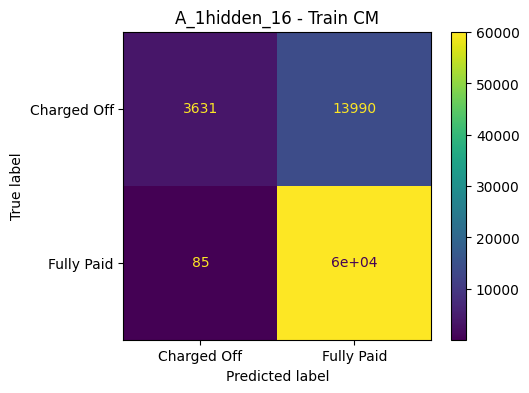

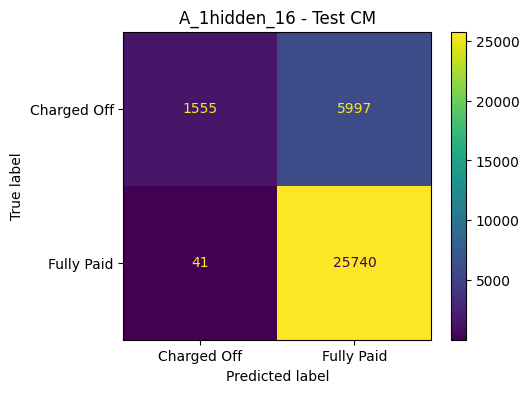


Model: B_2hidden_32_16


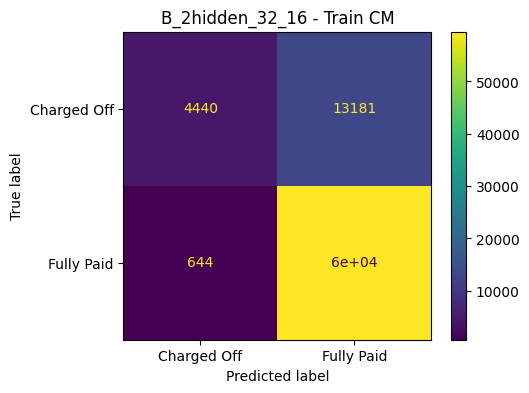

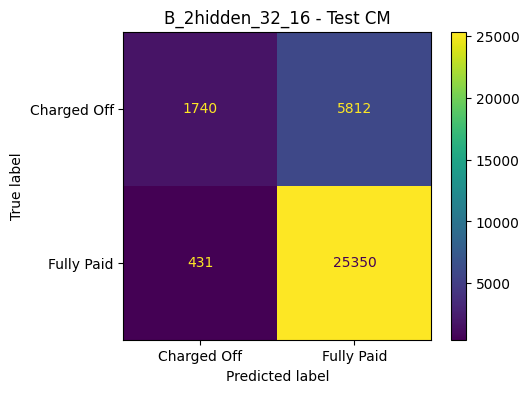


Model: C_3hidden_64_32_16


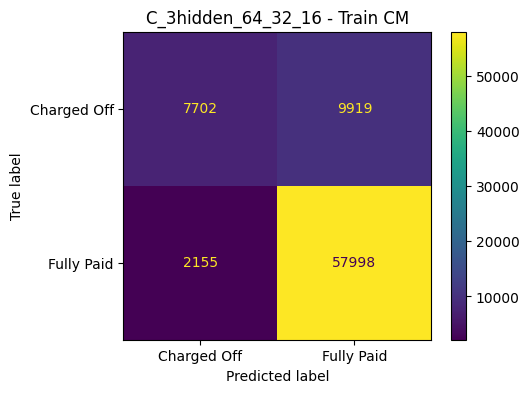

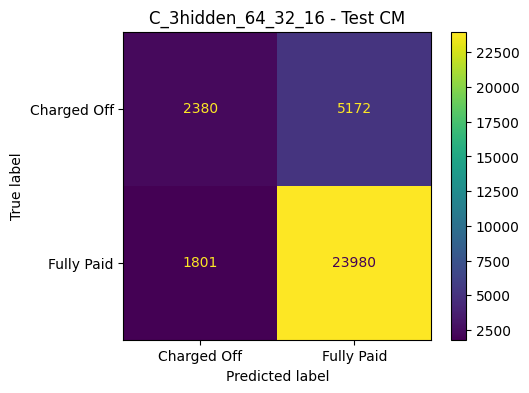


Model: D_1hidden_8


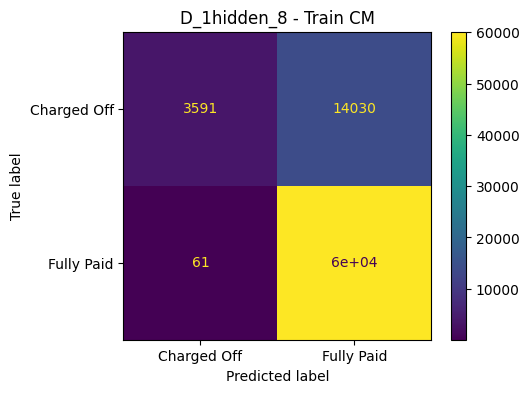

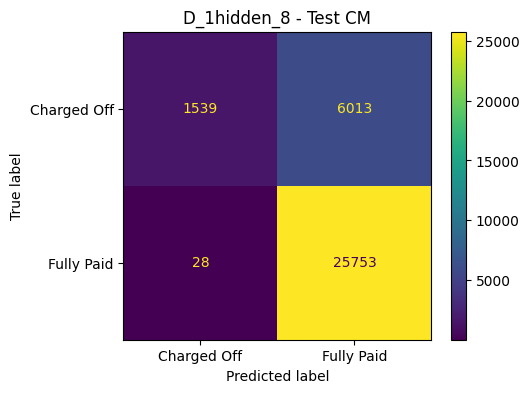

In [ ]:
# Confusion matrices
for name, res in results.items():
    print("\nModel:", name)
    cm_tr = confusion_matrix(y_train, res["y_train_pred"])
    disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr, display_labels=le_target.classes_)
    fig = plt.figure(figsize=(5,4))
    disp_tr.plot(ax=plt.gca())
    plt.title(f"{name} - Train CM")
    plt.show()
    cm_te = confusion_matrix(y_test, res["y_test_pred"])
    disp_te = ConfusionMatrixDisplay(confusion_matrix=cm_te, display_labels=le_target.classes_)
    fig = plt.figure(figsize=(5,4))
    disp_te.plot(ax=plt.gca())
    plt.title(f"{name} - Test CM")
    plt.show()